In [ ]:
!pip3 install nltk
!pip3 install gensim

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import LSTM,Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
from nltk import word_tokenize

from gensim.models import Word2Vec

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('/content/drive/MyDrive/tp_LAB/FinalTrainTest.csv')
df_val = pd.read_csv('/content/drive/MyDrive/tp_LAB/FinalValSet.csv')

In [3]:
df['Target'] = df['Target'].str.strip()
df['Target'] = df['Target'].str.replace('Nuetral','Neutral')

df_val['Target'] = df_val['Target'].str.strip()
df_val['Target'] = df_val['Target'].str.replace('Nuetral','Neutral')

In [4]:
df["Target"].loc[df["Target"]=="Negative"]=0.0
df["Target"].loc[df["Target"]=="Positive"]=1.0
df["Target"].loc[df["Target"]=="Neutral"]=2.0

df_val["Target"].loc[df_val["Target"]=="Negative"]=0.0
df_val["Target"].loc[df_val["Target"]=="Positive"]=1.0
df_val["Target"].loc[df_val["Target"]=="Neutral"]=2.0

In [5]:
all_df = pd.concat([df,df_val], ignore_index=True)

In [6]:
batch_size = 32

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# Word2Vec

In [7]:
sentences=[]
sum=0
for tweet in all_df['Phrase']:
    sents=word_tokenize(tweet)
    sum+=len(sents)
    sentences.append(sents) 

print(sum)
print(len(sentences))  

58162
5157


In [8]:
for te in sentences[:5]:
    print(te,"\n")

['lonely', 'best', 'way', 'focus', 'become', 'stronger', 'man', 'let', 'faith'] 

['call', 'keith', 'mystery'] 

['long', 'road', 'lonely', 'one', 'still', 'find', 'answers', 'im', 'chosen', 'one', 'promise'] 

['ship', 'chaos', 'escape', 'futile', 'emergency', 'repair', 'result', 'failure', 'fuels', 'exploding', 'survival', 'hopeless'] 

['ladies', 'lonely', 'come', 'keep', 'company'] 



In [9]:
w2v_model = Word2Vec(sentences=sentences,size=300,window=10,min_count=1)

In [10]:
w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

(526460, 581620)

In [11]:
vocab=w2v_model.wv.vocab
print("The total number of words are : ",len(vocab))

The total number of words are :  8154


In [12]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict))

The no of key-value pairs :  8154


In [13]:
tok = Tokenizer()
tok.fit_on_texts(all_df['Phrase'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(all_df['Phrase'])

In [14]:
pad_rev= pad_sequences(encd_rev)
pad_rev.shape 

(5157, 43)

In [15]:
df_1 = pad_rev[:5032]
df_val_2 = pad_rev[5032:]

In [16]:
y = df['Target']
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(df_1):
  X_train,X_test = df_1[train_index,:],df_1[test_index,:]
  y_train,y_test = y.iloc[train_index],y.iloc[test_index]

In [17]:
y_train = y_train.to_numpy().astype(np.float64)
y_test = y_test.to_numpy().astype(np.float64)

In [18]:
X_validation= df_val_2
X_validation.shape 

(125, 43)

In [19]:
y_validation = df_val['Target'].to_numpy().astype(np.float64)
y_validation.shape

(125,)

In [20]:
embed_matrix=np.zeros(shape=(vocab_size,300))
for word,i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  
    embed_matrix[i]=embed_vector

<h2>Hybrid model</h2>

In [22]:
hybrid_model = Sequential([
    Embedding(input_dim=vocab_size,output_dim=300,input_length=43,embeddings_initializer=Constant(embed_matrix)),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    LSTM(100),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [23]:
hybrid_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 300)           2445300   
                                                                 
 conv1d (Conv1D)             (None, 43, 32)            28832     
                                                                 
 batch_normalization (BatchN  (None, 43, 32)           128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 21, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 16)            1552      
                                                                 
 batch_normalization_1 (Batc  (None, 21, 16)           6

In [24]:
hybrid_model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

In [25]:
history = hybrid_model.fit(X_train, y_train, epochs=50, batch_size=batch_size,callbacks = [early_stopping],validation_data=(X_test,y_test))

Epoch 1/50
142/142 [==============================] - 15s 13ms/step - loss: 1.0651 - accuracy: 0.4069 - val_loss: 1.2421 - val_accuracy: 0.1789
Epoch 2/50
142/142 [==============================] - 1s 9ms/step - loss: 0.9580 - accuracy: 0.5246 - val_loss: 1.9000 - val_accuracy: 0.0616
Epoch 3/50
142/142 [==============================] - 1s 9ms/step - loss: 0.6795 - accuracy: 0.7198 - val_loss: 1.0143 - val_accuracy: 0.4036
Epoch 4/50
142/142 [==============================] - 1s 8ms/step - loss: 0.4572 - accuracy: 0.8390 - val_loss: 2.8480 - val_accuracy: 0.3360
Epoch 5/50
142/142 [==============================] - 1s 8ms/step - loss: 0.2825 - accuracy: 0.9134 - val_loss: 0.3498 - val_accuracy: 0.8728
Epoch 6/50
142/142 [==============================] - 1s 8ms/step - loss: 0.1960 - accuracy: 0.9371 - val_loss: 0.7747 - val_accuracy: 0.7356
Epoch 7/50
142/142 [==============================] - 1s 9ms/step - loss: 0.1522 - accuracy: 0.9556 - val_loss: 1.4966 - val_accuracy: 0.5189
Epoc

In [26]:
hybrid_model.evaluate(X_validation, y_validation)

4/4 [==============================] - 0s 20ms/step - loss: 2.2733 - accuracy: 0.5520


[2.2733371257781982, 0.5519999861717224]

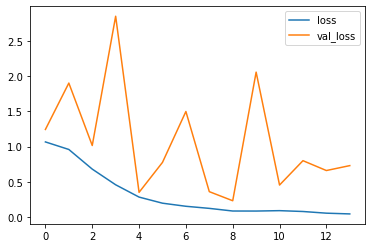

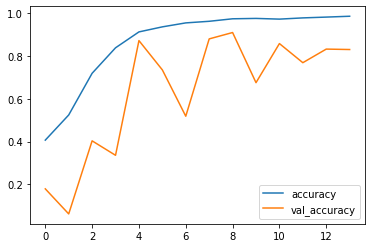

In [27]:
model_history = pd.DataFrame(history.history)
model_history.loc[:, ['loss', 'val_loss']].plot()
model_history.loc[:, ['accuracy', 'val_accuracy']].plot()

<h2>LSTM</h2>

In [21]:
lstm_model = Sequential([
    Embedding(input_dim=vocab_size,output_dim=300,input_length=43,embeddings_initializer=Constant(embed_matrix)),
    LSTM(100),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [22]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 300)           2445300   
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0

In [23]:
lstm_model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

In [24]:
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=batch_size,callbacks=[early_stopping],validation_data=(X_test,y_test))

Epoch 1/50
142/142 [==============================] - 5s 12ms/step - loss: 1.0803 - accuracy: 0.3762 - val_loss: 1.2802 - val_accuracy: 0.0000e+00
Epoch 2/50
142/142 [==============================] - 1s 7ms/step - loss: 1.0578 - accuracy: 0.3977 - val_loss: 1.1841 - val_accuracy: 0.0000e+00
Epoch 3/50
142/142 [==============================] - 1s 7ms/step - loss: 0.8993 - accuracy: 0.5529 - val_loss: 0.7518 - val_accuracy: 0.8111
Epoch 4/50
142/142 [==============================] - 1s 7ms/step - loss: 0.5630 - accuracy: 0.7719 - val_loss: 0.6983 - val_accuracy: 0.7157
Epoch 5/50
142/142 [==============================] - 1s 7ms/step - loss: 0.3054 - accuracy: 0.8958 - val_loss: 0.6190 - val_accuracy: 0.7575
Epoch 6/50
142/142 [==============================] - 1s 8ms/step - loss: 0.1722 - accuracy: 0.9534 - val_loss: 1.0846 - val_accuracy: 0.6282
Epoch 7/50
142/142 [==============================] - 1s 8ms/step - loss: 0.1197 - accuracy: 0.9611 - val_loss: 0.7216 - val_accuracy: 0.73

In [25]:
lstm_model.evaluate(X_validation, y_validation)

4/4 [==============================] - 0s 5ms/step - loss: 6.8238 - accuracy: 0.5200


[6.82384729385376, 0.5199999809265137]

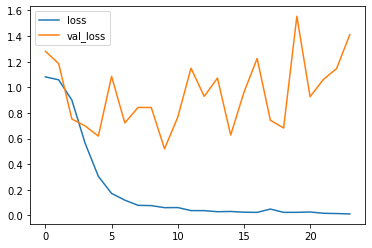

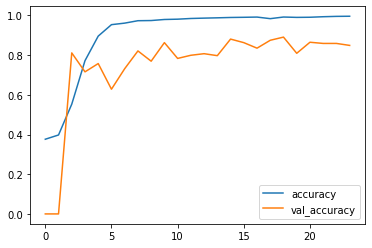

In [26]:
model_history = pd.DataFrame(history_lstm.history)
model_history.loc[:, ['loss', 'val_loss']].plot()
model_history.loc[:, ['accuracy', 'val_accuracy']].plot()